In [1]:
import os, sys
sys.path.append(os.path.abspath('../..'))
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import floris.tools as wfct
import floris.tools.cut_plane as cp
import floris.tools.wind_rose as rose
import floris.tools.power_rose as pr
import floris.tools.visualization as vis

In [2]:
# file_dir = os.path.dirname(os.path.abspath(''))
# print(file_dir)
fi = wfct.floris_interface.FlorisInterface("../../../examples/example_input.json")

In [3]:
# Define wind farm coordinates and layout
wf_coordinate = [39.8283, -98.5795]

# Below minimum wind speed, assumes power is zero.
minimum_ws = 3.0

In [4]:
# Set wind farm to N_row x N_row grid with constant spacing
# (2 x 2 grid, 5 D spacing)
D = fi.floris.farm.turbines[0].rotor_diameter
N_row = 2
spc = 5
layout_x = []
layout_y = []
for i in range(N_row):
    for k in range(N_row):
        layout_x.append(i * spc * D)
        layout_y.append(k * spc * D)
N_turb = len(layout_x)

In [5]:
layout_x, layout_y

([0.0, 0.0, 630.0, 630.0], [0.0, 630.0, 0.0, 630.0])

In [6]:
fi.reinitialize_flow_field(
    layout_array=(layout_x, layout_y), wind_direction=[270.0], wind_speed=[8.0]
)
fi.calculate_wake()

Text(0.5, 1.0, 'Baseline flow for U = 8 m/s, Wind Direction = 270$^\\circ$')

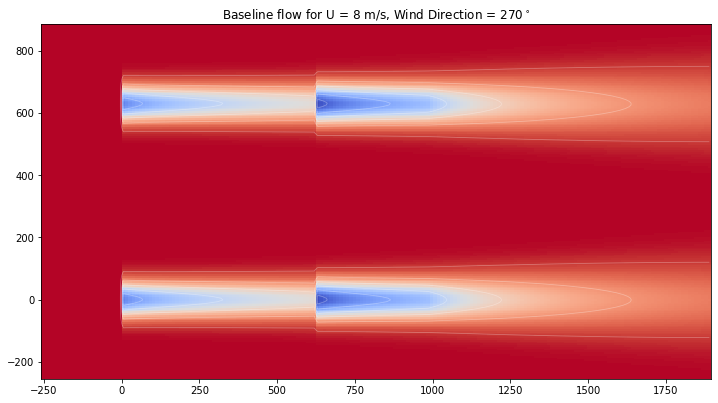

In [7]:
# Initialize the horizontal cut
hor_plane = fi.get_hor_plane(height=fi.floris.farm.turbines[0].hub_height + 0)

# Plot and show
fig, ax = plt.subplots(figsize=(12, 8))
wfct.visualization.visualize_cut_plane(hor_plane, ax=ax)
ax.set_title("Baseline flow for U = 8 m/s, Wind Direction = 270$^\\circ$")

Correcting negative Overhang:-7.5


<PolarAxesSubplot:>

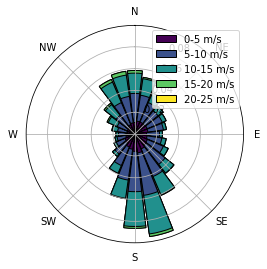

In [13]:
# Create wind rose object and import wind rose dataframe using WIND Toolkit
# HSDS API. Alternatively, load existing file with wind rose information.
calculate_new_wind_rose = False

wind_rose = rose.WindRose()

if calculate_new_wind_rose:

    wd_list = np.arange(0, 360, 5)
    print(wd_list)
    ws_list = np.arange(0, 26, 1)
    print(ws_list)

    df = wind_rose.import_from_wind_toolkit_hsds(
        wf_coordinate[0],
        wf_coordinate[1],
        ht=100,
        wd=wd_list,
        ws=ws_list,
        limit_month=None,
        st_date=None,
        en_date=None,
    )
    print(df)

else:
    df = wind_rose.load("./windtoolkit_geo_center_us.p")

# plot wind rose
wind_rose.plot_wind_rose()

In [17]:
df.head(50)

,ws,wd,freq_val
0,0.0,0.0,0.000016
1,0.0,5.0,0.000016
2,0.0,10.0,0.000049
3,0.0,15.0,0.000033
4,0.0,20.0,0.000065
5,0.0,25.0,0.000065
6,0.0,30.0,0.000016
7,0.0,35.0,0.000000
8,0.0,40.0,0.000033
9,0.0,45.0,0.000049


In [16]:
df.columns

Index(['ws', 'wd', 'freq_val'], dtype='object')

In [18]:
# Determine baseline power with and without wakes

# Put results in dict for speed
power_dict = dict()

for i in range(len(df.wd)):
    # print(
    #     "Computing wind speed, wind direction pair "
    #     + str(i)
    #     + " out of "
    #     + str(len(df.wd))
    #     + ": wind speed = "
    #     + str(df.ws[i])
    #     + " m/s, wind direction = "
    #     + str(df.wd[i])
    #     + " deg."
    # )

    if df.ws[i] >= minimum_ws:
        fi.reinitialize_flow_field(wind_direction=[df.wd[i]], wind_speed=[df.ws[i]])

        # calculate baseline power
        fi.calculate_wake()
        power_base = fi.get_turbine_power()

        # calculate power for no wake case
        fi.calculate_wake(no_wake=True)
        power_no_wake = fi.get_turbine_power(no_wake=True)
    else:
        power_base = N_turb * [0.0]
        power_no_wake = N_turb * [0.0]

    power_dict[i] = {
        "ws": df.ws[i],
        "wd": df.wd[i],
        "power_baseline": np.sum(power_base),
        "turbine_power_baseline": power_base,
        "power_no_wake": np.sum(power_no_wake),
        "turbine_power_no_wake": power_no_wake,
    }

c:\users\li hang\documents\projects\floris\floris\simulation\wake_deflection\gauss.py:209: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaNum = (1.6 + np.sqrt(M0)) * (
c:\users\li hang\documents\projects\floris\floris\simulation\wake_deflection\gauss.py:210: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) - np.sqrt(M0)
c:\users\li hang\documents\projects\floris\floris\simulation\wake_deflection\gauss.py:212: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaDen = (1.6 - np.sqrt(M0)) * (
c:\users\li hang\documents\projects\floris\floris\simulation\wake_deflection\gauss.py:213: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) + np.sqrt(M0)
c:\users\li hang\documents\projects\floris\floris\simulation\wake_deflection\gauss.py:219: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(sigma_y0 * sigma_z0 / (ky * kz * M0))


In [19]:
len(power_dict)

1872

In [21]:
power_dict

{0: {'ws': 0.0,
  'wd': 0.0,
  'power_baseline': 0.0,
  'turbine_power_baseline': [0.0, 0.0, 0.0, 0.0],
  'power_no_wake': 0.0,
  'turbine_power_no_wake': [0.0, 0.0, 0.0, 0.0]},
 1: {'ws': 0.0,
  'wd': 5.0,
  'power_baseline': 0.0,
  'turbine_power_baseline': [0.0, 0.0, 0.0, 0.0],
  'power_no_wake': 0.0,
  'turbine_power_no_wake': [0.0, 0.0, 0.0, 0.0]},
 2: {'ws': 0.0,
  'wd': 10.0,
  'power_baseline': 0.0,
  'turbine_power_baseline': [0.0, 0.0, 0.0, 0.0],
  'power_no_wake': 0.0,
  'turbine_power_no_wake': [0.0, 0.0, 0.0, 0.0]},
 3: {'ws': 0.0,
  'wd': 15.0,
  'power_baseline': 0.0,
  'turbine_power_baseline': [0.0, 0.0, 0.0, 0.0],
  'power_no_wake': 0.0,
  'turbine_power_no_wake': [0.0, 0.0, 0.0, 0.0]},
 4: {'ws': 0.0,
  'wd': 20.0,
  'power_baseline': 0.0,
  'turbine_power_baseline': [0.0, 0.0, 0.0, 0.0],
  'power_no_wake': 0.0,
  'turbine_power_no_wake': [0.0, 0.0, 0.0, 0.0]},
 5: {'ws': 0.0,
  'wd': 25.0,
  'power_baseline': 0.0,
  'turbine_power_baseline': [0.0, 0.0, 0.0, 0.0],
  

In [27]:
df_base = pd.DataFrame.from_dict(power_dict, "index")
df_base

,ws,wd,power_baseline,turbine_power_baseline,power_no_wake,turbine_power_no_wake
0,0.0,0.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
1,0.0,5.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
2,0.0,10.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
3,0.0,15.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
4,0.0,20.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...
1867,25.0,335.0,2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."
1868,25.0,340.0,2.045318e+07,"[5113294.707440896, 5113294.707442147, 5113294...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."
1869,25.0,345.0,2.045318e+07,"[5113294.564385012, 5113294.707442147, 5113294...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."
1870,25.0,350.0,2.045261e+07,"[5113011.230765772, 5113294.707442147, 5113010...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."


In [28]:
df_base.reset_index(drop=True, inplace=True)
df_base

,ws,wd,power_baseline,turbine_power_baseline,power_no_wake,turbine_power_no_wake
0,0.0,0.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
1,0.0,5.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
2,0.0,10.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
3,0.0,15.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
4,0.0,20.0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",0.000000e+00,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...
1867,25.0,335.0,2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."
1868,25.0,340.0,2.045318e+07,"[5113294.707440896, 5113294.707442147, 5113294...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."
1869,25.0,345.0,2.045318e+07,"[5113294.564385012, 5113294.707442147, 5113294...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."
1870,25.0,350.0,2.045261e+07,"[5113011.230765772, 5113294.707442147, 5113010...",2.045318e+07,"[5113294.707442147, 5113294.707442147, 5113294..."


Norming frequency total of 1.00 to 1.0
Case Example 2 x 2 Wind Farm has results:
-	No-Wake		Baseline 
---------------------------------------------
AEP (GWh)	7.8E+01		7.4E+01
%	--		94.8%
Wk Loss	--		5.2%


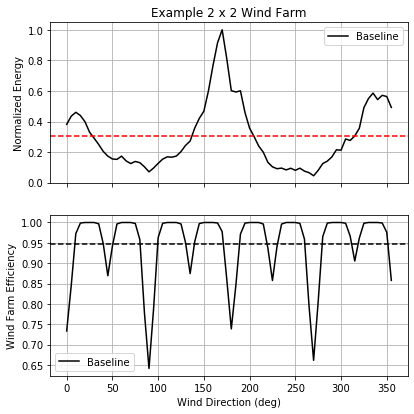

In [12]:
# Initialize power rose
case_name = "Example " + str(N_row) + " x " + str(N_row) + " Wind Farm"
power_rose = pr.PowerRose()
power_rose.make_power_rose_from_user_data(
    case_name, df, df_base["power_no_wake"], df_base["power_baseline"]
)

# Display AEP analysis
fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(6.4, 6.5))
power_rose.plot_by_direction(axarr)
power_rose.report()

plt.show()